In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy as sp
import control as ct
import control.matlab as matlab
from HelperFunctions import *
from scipy.signal import butter, lfilter

%matplotlib notebook

In [2]:
# Define the Space state model. X = [x, x_dot] U = [u*] Y = [x], x = [height], u* = [thrust + gravity]
# Gravity applied only to Z double dot

sim_dur = 100
sample_rate = 1000 # Hz
t = np.linspace(0, sim_dur, int(sim_dur*sample_rate), endpoint=False)

g = 9.81
tau1 = 0.2 # The units are 1/sec  -- value of 10 was giving a weird response
m = 2 # The units are kg
a = 10 

A1 = np.array([[0, 1, 0], [0, 0, 1/m], [0, 0, -1/tau1]])
B = np.array([[0], [0], [a]])
L = np.array([[0], [-1], [0]])
C = np.array([[1, 0, 0]])
D = np.array([[0]])


# First Neglecting the g term and calculating the K values with LQR:

In [3]:
Q_lqr = np.array([[5, 0, 0],[0, 1, 0], [0, 0, 1]])
R_lqr = 1
K_lqr1, P_lqr1, E1 = matlab.lqr(A1, B, Q_lqr, R_lqr)

# Now we will simulate the system with the LQR controller

In [4]:
iterations = len(t)
T = 1/iterations
# Wanted height:
h = 10

# requested state:
r = np.array([[h], [0], [0]])

# First, define the system dynamics for both systems
def system(state, t, A, B, K, r, L, g):
    # state is the current state vector
    # Calculate control input u = -K(x-r)
    u = -K @ (state.reshape(-1,1) - r)
    # Calculate state derivative
    state_dot = (A @ state.reshape(-1,1) + B * u.item() + L * g).flatten()
    return state_dot

# Initial conditions
x1_0 = np.zeros(np.size(A1,0))  # Initial state for system 1

# Solve ODEs
x1_solution = sp.integrate.odeint(system, x1_0, t, args=(A1, B, K_lqr1, r, L, 0))

# Extract states (x1_solution and x2_solution will be arrays of shape (iterations, 3))
# If you need column vectors, reshape:
x1_ = x1_solution.T.reshape(3, iterations, 1)

# Calculate control inputs
u1_ = np.zeros(iterations)
for i in range(iterations):
    u1_[i] = (-K_lqr1 @ (x1_[:,i]-r)).item()

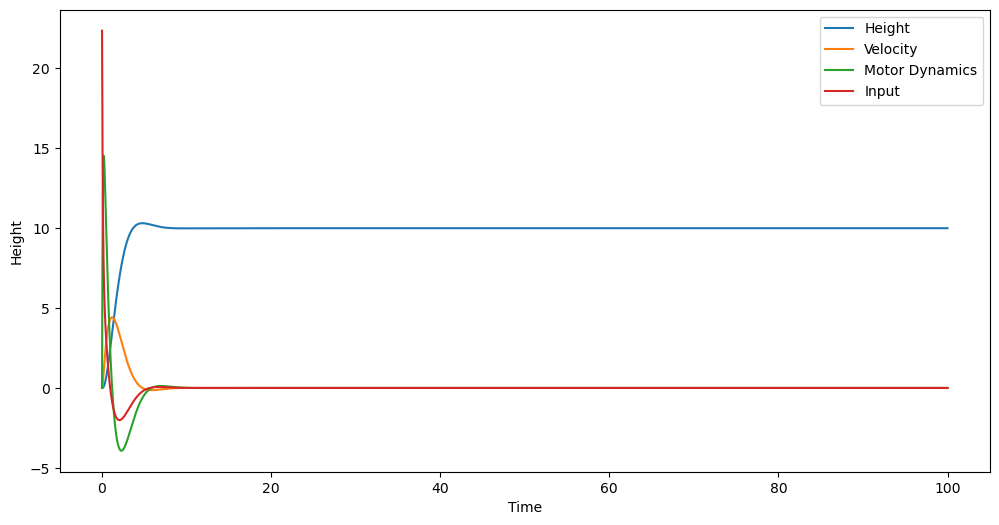

In [5]:
plt.figure(figsize=(12,6))
plt.plot(t, x1_[0,:], label='Height')
plt.plot(t, x1_[1,:], label='Velocity')
plt.plot(t, x1_[2,:], label='Motor Dynamics')
plt.plot(t, u1_, label='Input')
plt.xlabel('Time')
plt.ylabel('Height')
plt.legend()

# Creating Measurements

### Creating a periodic signal - u
u is the PWM signal from the controller. varying from 1000 us to 2000 us

In [5]:
u_adp = create_input_signal(t, noise_std=10, noise_freq=100, cycle_time=5)

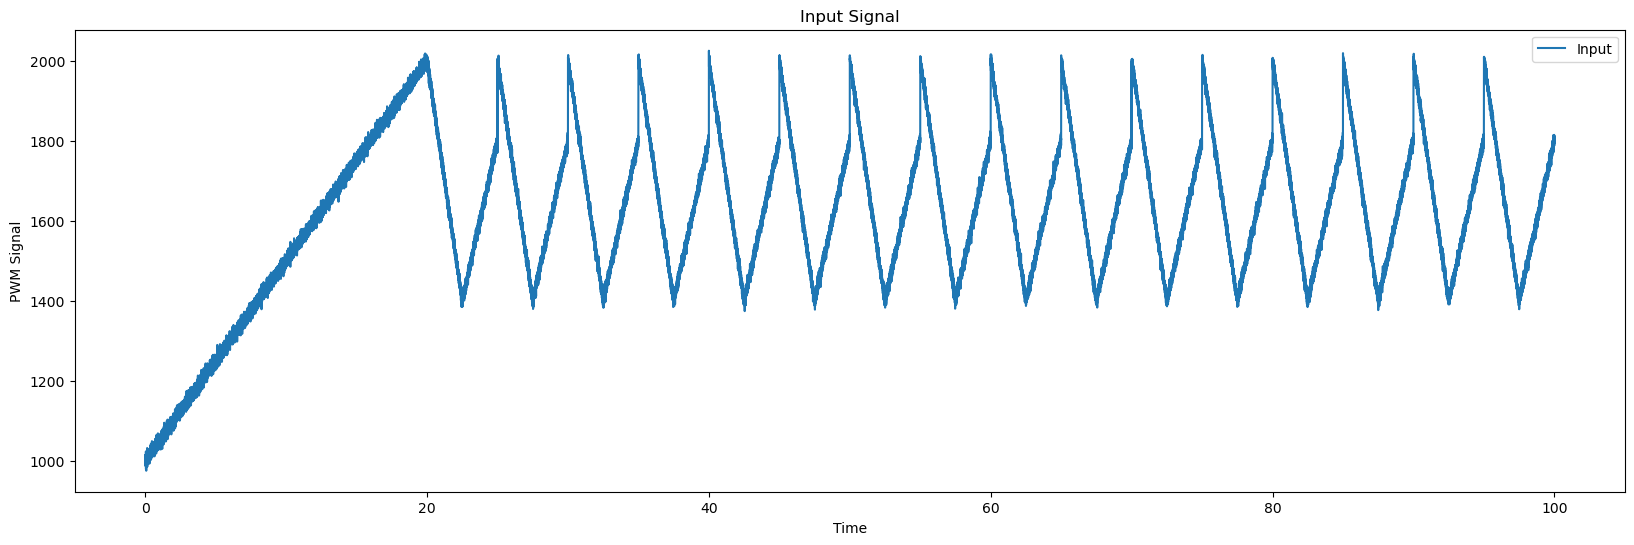

In [17]:
plt.figure(figsize=(20,6))
plt.plot(t, u_adp, label='Input')
plt.xlabel('Time')
plt.ylabel('PWM Signal')
plt.title('Input Signal')
plt.legend()

### Generating measurements

In [6]:
def system_adp(state, t, A, B, u_func, t_vec, L, g):
    # Interpolate u at the current time point
    u = np.interp(t, t_vec, u_func)
    # Calculate state derivative
    state_dot = (A @ state.reshape(-1,1) + B * u + L * g).flatten()
    return state_dot

# Initial conditions
x1_0_adp = np.zeros(np.size(A1,0))

# Solve ODEs
x1_solution_adp = sp.integrate.odeint(system_adp, x1_0_adp, t, 
                                    args=(A1, B, u_adp, t, L, g))

# Reshape solutions to match your original format
x1_adp = x1_solution_adp.T

# If you need x_dot values, you can calculate them:
x_dot1_adp = np.zeros_like(x1_adp)

for i in range(len(t)):
    x_dot1_adp[:,i] = system_adp(x1_adp[:,i], t[i], A1, B, u_adp, t, L, g)

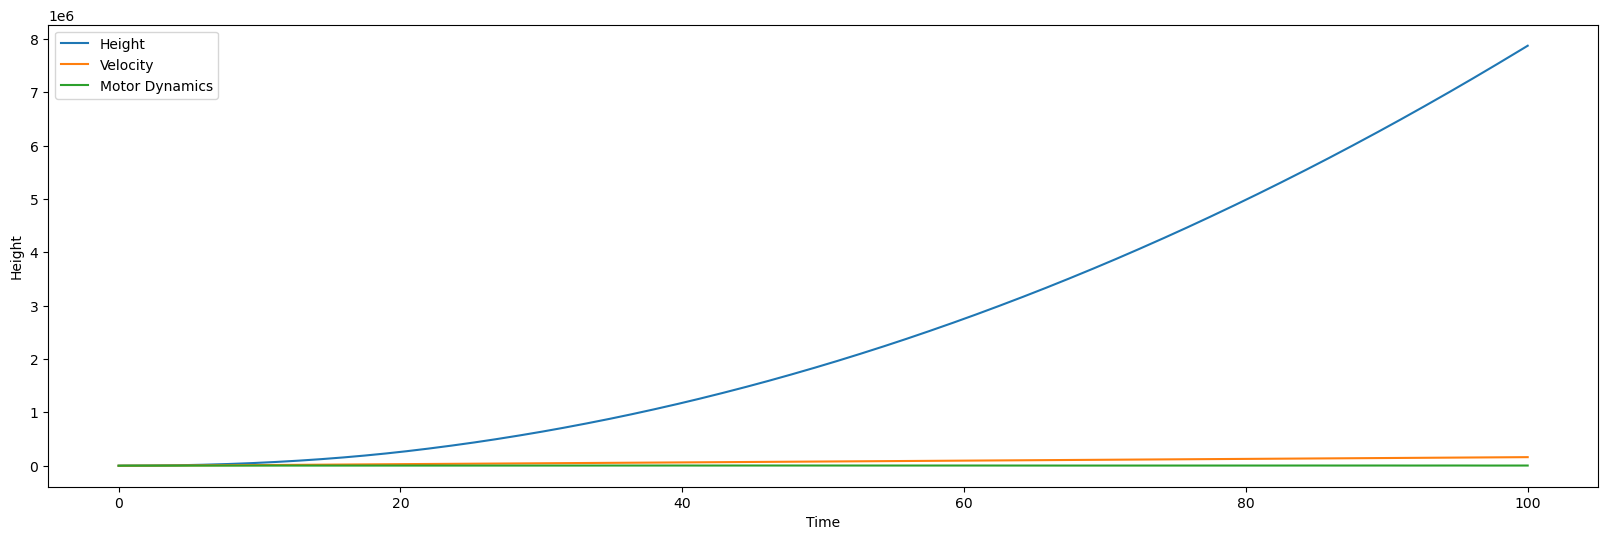

In [36]:
plt.figure(figsize=(20,6))
plt.plot(t, x1_adp[0,:], label='Height')
plt.plot(t, x1_adp[1,:], label='Velocity')
plt.plot(t, x1_adp[2,:], label='Motor Dynamics')
plt.xlabel('Time')
plt.ylabel('Height')
plt.legend()

# Adding HPF to the measurements and then applying the ADP algorithm

In [7]:
fs = 1/(t[1]-t[0])
cutoff_freq = 0.5# Hz. Trying to remove the gravity

# Filter u measurements
u_adp_HPF = apply_highpass_filter(u_adp, cutoff_freq, fs)

# Filter x measurements (apply to each state)
x1_adp_HPF = np.zeros_like(x1_adp)
for i in range(x1_adp.shape[0]):
    x1_adp_HPF[i,:] = apply_highpass_filter(x1_adp[i,:], cutoff_freq, fs)


In [86]:
plt.figure(figsize=(12,6))
plt.plot(t, u_adp_HPF, label='Input')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.title('Input Signal with HPF')
plt.legend()

plt.figure(figsize=(12,6))
plt.plot(t, x1_adp_HPF[0,:], label='Height')
plt.plot(t, x1_adp_HPF[1,:], label='Velocity')
plt.plot(t, x1_adp_HPF[2,:], label='Motor Dynamics')
plt.xlabel('Time')
plt.ylabel('State')
plt.title('Height Control with tau = 2 with HPF')
plt.legend()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
n = np.size(x1_adp_HPF,0)
kron_xx = np.empty((0, n**2))
kron_xu = np.empty((0, n))
delta_x = np.empty((0, n**2))
Ixx = np.empty((0, n**2)) # Initialize as an empty 2D array with shape (0, 2)
Ixu = np.empty((0, n))
dT = np.arange(0,iterations*T+T,T)
l = n*(n+1)//2+n*1 # u is scalar so m=1. we have 2 states, therefore 2 equations. Q is 2x2. defining l this way will help us to set the window of the integrations in order to get a valid dimensions for Ixx and Ixu
intr = int(iterations//(l+600)) # defining the interval for the integrations. this interval will give us Ixx and Ixu with the ammount of equations needed. In our case 2 equations.

for i in range(intr,iterations, intr):
    x_i = x1_adp_HPF[:,i]
    x_i_1 = x1_adp_HPF[:,i-intr]
    delta_xx_i = np.kron(x_i, x_i) - np.kron(x_i_1, x_i_1)
    delta_x = np.vstack((delta_x, [delta_xx_i]))

    
for i in range(0,iterations):
    x_i = x1_adp_HPF[:,i]
    u_i = u_adp_HPF[i]
    kron_xx_i = np.kron(x_i, x_i)
    kron_xu_i = np.kron(x_i, u_i)
    kron_xx = np.vstack((kron_xx, [kron_xx_i]))
    kron_xu = np.vstack((kron_xu, [kron_xu_i]))

for i in range(intr,iterations, intr):
    window = slice(max(0, i-intr), i+1)  # This defines the time steps t0 to t1 etc.
    new_Ixu = np.trapz(kron_xu[window,:], dT[window], axis = 0)
    new_Ixx = np.trapz(kron_xx[window,:], dT[window], axis =0)
    Ixu = np.vstack((Ixu, [new_Ixu]))
    Ixx = np.vstack((Ixx, [new_Ixx]))

In [10]:
n = np.size(x1_adp,0)
Q = np.array([[5, 0, 0],[0, 1, 0], [0, 0, 1]])
m = 1
R_ = np.array([[1]])
K_i = 0.2 * K_lqr1 # starting with a stabilizing control value
N_ = create_N_matrix(n)

K_adp = np.empty((0, np.size(x1_adp,0)))
P_adp = []
P_i_old = np.zeros_like(Q)

norm_Pi = np.array([])

for i in range(1,iterations):
    # Calculating Q_i:
    Q_i = Q + K_i.T @ R_ @ K_i
    
    # Calculating Y_i:
    Y_i = -Ixx @ vec(Q_i) # Shai added - in the begining
    X_i = np.hstack((delta_x @ N_, -2* Ixx@np.kron(np.eye(n), K_i.T @ R_) -2*Ixu @ np.kron(np.eye(n), R_)))
    
    # Calculating Theta_i:
    Theta_i = np.linalg.lstsq(X_i, Y_i, rcond=None)[0]
    
    vecP_i = N_ @ Theta_i[:(n**2-n*m )]
    P_i = vec2matrix(vecP_i)
    norm_Pi = np.append(norm_Pi, np.linalg.norm(P_i))
    
    K_i = Theta_i[(n**2-2*m-1):].reshape(K_lqr1.shape)

    
    K_adp = np.vstack((K_adp, K_i))
    P_adp.append(P_i)
    
    if abs(np.linalg.norm(P_i_old - P_i)) < 0.01:
        print('Converged')
        
        break
    
    P_i_old = P_i
    

Converged


In [12]:
print('ADP Calculated gaines:', K_adp[-1])
print('LQR Based gaines:', K_lqr1)

ADP Calculated gaines: [2.18490533 3.46172772 0.76820842]
LQR Based gaines: [[2.23606798 3.50957149 0.76528935]]


### Trying to take the measurements after the convergence of the HPF

In [35]:
# Find index corresponding to 5 seconds
start_time = 5  # seconds
start_idx = int(start_time * sample_rate)

# Adjust your data to start from 5 seconds
x1_adp_HPF_cut = x1_adp_HPF[:, start_idx:]
u_adp_HPF_cut = u_adp_HPF[start_idx:]
iterations_cut = len(u_adp_HPF_cut)

# Adjust time vector
dT = np.arange(0, iterations_cut*T+T, T)

# Initialize arrays
n = np.size(x1_adp_HPF,0)
kron_xx = np.empty((0, n**2))
kron_xu = np.empty((0, n))
delta_x = np.empty((0, n**2))
Ixx = np.empty((0, n**2))
Ixu = np.empty((0, n))

# Calculate l and intr with new iterations
l = n*(n+1)//2+n*1
intr = int(iterations_cut//(l+50))

# Your loops now using the cut data
for i in range(intr, iterations_cut, intr):
    x_i = x1_adp_HPF_cut[:,i]
    x_i_1 = x1_adp_HPF_cut[:,i-intr]
    delta_xx_i = np.kron(x_i, x_i) - np.kron(x_i_1, x_i_1)
    delta_x = np.vstack((delta_x, [delta_xx_i]))

for i in range(0, iterations_cut):
    x_i = x1_adp_HPF_cut[:,i]
    u_i = u_adp_HPF_cut[i]
    kron_xx_i = np.kron(x_i, x_i)
    kron_xu_i = np.kron(x_i, u_i)
    kron_xx = np.vstack((kron_xx, [kron_xx_i]))
    kron_xu = np.vstack((kron_xu, [kron_xu_i]))

for i in range(intr, iterations_cut, intr):
    window = slice(max(0, i-intr), i+1)
    new_Ixu = np.trapz(kron_xu[window,:], dT[window], axis = 0)
    new_Ixx = np.trapz(kron_xx[window,:], dT[window], axis =0)
    Ixu = np.vstack((Ixu, [new_Ixu]))
    Ixx = np.vstack((Ixx, [new_Ixx]))

In [36]:
n = np.size(x1_adp,0)
Q = np.array([[5, 0, 0],[0, 1, 0], [0, 0, 1]])
m = 1
R_ = np.array([[1]])
K_i = 0.2 * K_lqr1 # starting with a stabilizing control value
N_ = create_N_matrix(n)

K_adp = np.empty((0, np.size(x1_adp,0)))
P_adp = []
P_i_old = np.zeros_like(Q)

norm_Pi = np.array([])

for i in range(1,iterations):
    # Calculating Q_i:
    Q_i = Q + K_i.T @ R_ @ K_i
    
    # Calculating Y_i:
    Y_i = -Ixx @ vec(Q_i) # Shai added - in the begining
    X_i = np.hstack((delta_x @ N_, -2* Ixx@np.kron(np.eye(n), K_i.T @ R_) -2*Ixu @ np.kron(np.eye(n), R_)))
    
    # Calculating Theta_i:
    Theta_i = np.linalg.lstsq(X_i, Y_i, rcond=None)[0]
    
    vecP_i = N_ @ Theta_i[:(n**2-n*m )]
    P_i = vec2matrix(vecP_i)
    norm_Pi = np.append(norm_Pi, np.linalg.norm(P_i))
    
    K_i = Theta_i[(n**2-2*m-1):].reshape(K_lqr1.shape)

    
    K_adp = np.vstack((K_adp, K_i))
    P_adp.append(P_i)
    
    if abs(np.linalg.norm(P_i_old - P_i)) < 0.01:
        print('Converged')
        
        break
    
    P_i_old = P_i
    

Converged


In [37]:
print('ADP Calculated gaines:', K_adp[-1])
print('LQR Based gaines:', K_lqr1)

ADP Calculated gaines: [2.2405948  3.27217141 0.76792402]
LQR Based gaines: [[2.23606798 3.50957149 0.76528935]]
